<a href="https://colab.research.google.com/github/JA4S/JAX-AMR/blob/main/examples/jax_amr_basic_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JAX-AMR and import relevant libraries

In [ ]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/JA4S/JAX-AMR.git
!wget https://raw.githubusercontent.com/JA4S/JAX-AMR/main/examples/simple_solver.py

  Cloning https://github.com/JA4S/JAX-AMR.git to /tmp/pip-req-build-pg3ba0ml
  Running command git clone --filter=blob:none --quiet https://github.com/JA4S/JAX-AMR.git /tmp/pip-req-build-pg3ba0ml
  Resolved https://github.com/JA4S/JAX-AMR.git to commit ff8aa0947e5cce4e9f52febab5602e5b9d982728
  Preparing metadata (setup.py) ... done
  Created wheel for jaxamr: filename=jaxamr-0.1-py3-none-any.whl size=7661 sha256=1b26de7009f81c51f32502f9e98697ec6de4a189200bf86bef4e98944875508f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mf96go1f/wheels/d9/bd/41/7650f74abb843dacaedad51fa30a349daba1c5b4f30994990c
Successfully built jaxamr
--2025-04-23 01:45:29--  https://raw.githubusercontent.com/JA4S/JAX-AMR/main/examples/simple_solver.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
from jaxamr import amr, amraux
import simple_solver as solver

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

# Set computation parameters

In [ ]:
Lx = 1.0
Ly = 1.0

nx = 200
ny = 200

dx = Lx/nx
dy = Ly/ny

base_grid = {'Lx':Lx,'Ly':Ly,'Nx':nx,'Ny':ny}

n_block = [
    [1, 1],  # Level 0
    [20, 20], # Level 1
    [2, 2],  # Level 2
    [2, 2],  # Level 3
    [2, 2]   # Level 4
] # x-direction, y-direction

template_node_num = 1

buffer_num = 2

refinement_tolerance = {
    'density': 5.0,
    'velocity': 0.5
}

amr_config = {'base_grid':base_grid,
        'n_block':n_block,
        'template_node_num':template_node_num,
        'buffer_num':buffer_num,
        'refinement_tolerance':refinement_tolerance
}

amr.set_amr(amr_config)

dx = [dx] # Grid size in refinement levels
dy = [dy]
for i, (bx, by) in enumerate(n_block[1:], 1):
    dx.append(Lx/nx / (2.0**i))
    dy.append(Ly/ny / (2.0**i))

# Initilization

In [ ]:
X, Y, U = solver.initialize(nx, ny)

blk_data0 = jnp.array([U])

blk_info0 = {
      'number': 1,
      'index': jnp.array([0, 0, 0]),
      'glob_index': jnp.array([[0, 0]]),
      'neighbor_index': jnp.array([[-1, -1, -1, -1]])
        }

# AMR main loop

In [ ]:
dt = 0.00006 * 8  # time step

nt = 30 # computation step

amr_update_step = 2 # AMR update step

amr_initialized = False

for step in tqdm(range(nt), desc="Progress", unit="step"):

    if amr_initialized == False :

        blk_data1, blk_info1, max_blk_num1 = amr.initialize(1, blk_data0, blk_info0, 'density', dx[1], dy[1])
        blk_data2, blk_info2, max_blk_num2 = amr.initialize(2, blk_data1, blk_info1, 'density', dx[2], dy[2])
        blk_data3, blk_info3, max_blk_num3 = amr.initialize(3, blk_data2, blk_info2, 'density', dx[3], dy[3])

        amr_initialized = True

    elif (step % amr_update_step == 0):
        blk_data1, blk_info1, max_blk_num1 = amr.update(1, blk_data0, blk_info0, 'density', dx[1], dy[1], blk_data1, blk_info1, max_blk_num1)
        blk_data2, blk_info2, max_blk_num2 = amr.update(2, blk_data1, blk_info1, 'density', dx[2], dy[2], blk_data2, blk_info2, max_blk_num2)
        blk_data3, blk_info3, max_blk_num3 = amr.update(3, blk_data2, blk_info2, 'density', dx[3], dy[3], blk_data3, blk_info3, max_blk_num3)

    '''Crossover advance'''
    for _ in range(2):
        for _ in range(2):
            for _ in range(2):
                blk_data3 = solver.rk2(3, blk_data2, dx[3], dy[3], dt/8.0, blk_data3, blk_info3)
            blk_data2 = solver.rk2(2, blk_data1, dx[2], dy[2], dt/4.0, blk_data2, blk_info2)
        blk_data1 = solver.rk2(1, blk_data0, dx[1], dy[1], dt/2.0, blk_data1, blk_info1)
    blk_data0 = solver.rk2_L0(blk_data0, dx[0], dy[0], dt)


    '''Synchronous advance'''
    #blk_data3 = solver.rk2(3, blk_data2, dx[3], dy[3], dt/8.0, blk_data3, blk_info3)
    #blk_data2 = solver.rk2(2, blk_data1, dx[2], dy[2], dt/8.0, blk_data2, blk_info2)
    #blk_data1 = solver.rk2(1, blk_data0, dx[1], dy[1], dt/8.0, blk_data1, blk_info1)
    #blk_data0 = solver.rk2_L0(blk_data0, dx[0], dy[0], dt/8.0)


    blk_data2 = amr.interpolate_fine_to_coarse(3, blk_data2, blk_data3, blk_info3)
    blk_data1 = amr.interpolate_fine_to_coarse(2, blk_data1, blk_data2, blk_info2)
    blk_data0 = amr.interpolate_fine_to_coarse(1, blk_data0, blk_data1, blk_info1)

Progress:   0%|          | 0/30 [00:00<?, ?step/s]


AMR Initialized at Level [1] with [40] blocks

AMR Initialized at Level [2] with [80] blocks

AMR Initialized at Level [3] with [170] blocks

AMR max_blk_num Updated as[ 80 ] at Level [ 1 ]

AMR Updated at Level [1] with [40/80] blocks [valid/max]

AMR Updated at Level [2] with [68/80] blocks [valid/max]

AMR Updated at Level [3] with [156/170] blocks [valid/max]

AMR Updated at Level [1] with [40/80] blocks [valid/max]

AMR Updated at Level [2] with [70/80] blocks [valid/max]

AMR max_blk_num Updated as[ 340 ] at Level [ 3 ]

AMR Updated at Level [3] with [190/340] blocks [valid/max]

AMR Updated at Level [1] with [40/80] blocks [valid/max]

AMR Updated at Level [2] with [78/80] blocks [valid/max]

AMR Updated at Level [3] with [202/340] blocks [valid/max]

AMR Updated at Level [1] with [40/80] blocks [valid/max]

AMR max_blk_num Updated as[ 160 ] at Level [ 2 ]

AMR Updated at Level [2] with [87/160] blocks [valid/max]

AMR Updated at Level [3] with [216/340] blocks [valid/max]

AMR

# Result Visualization

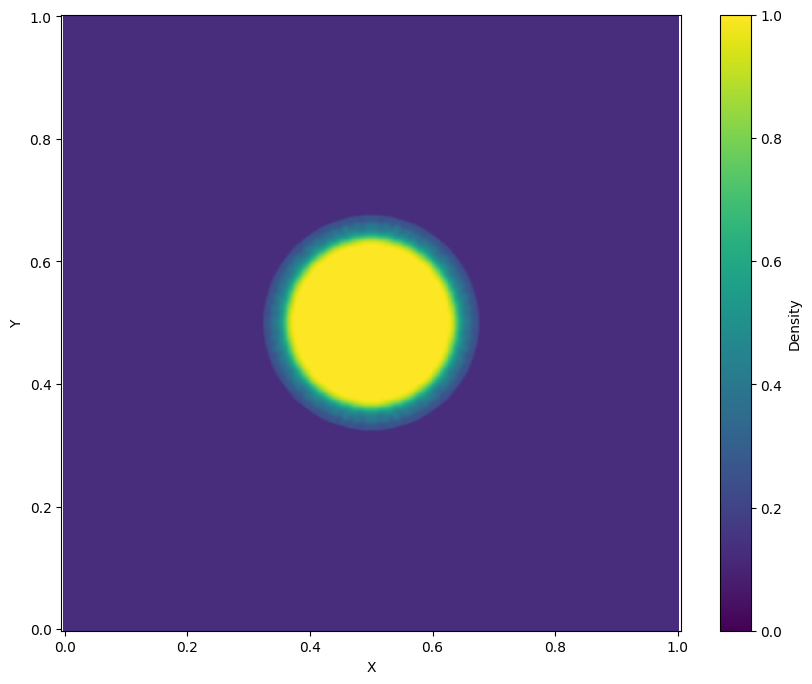

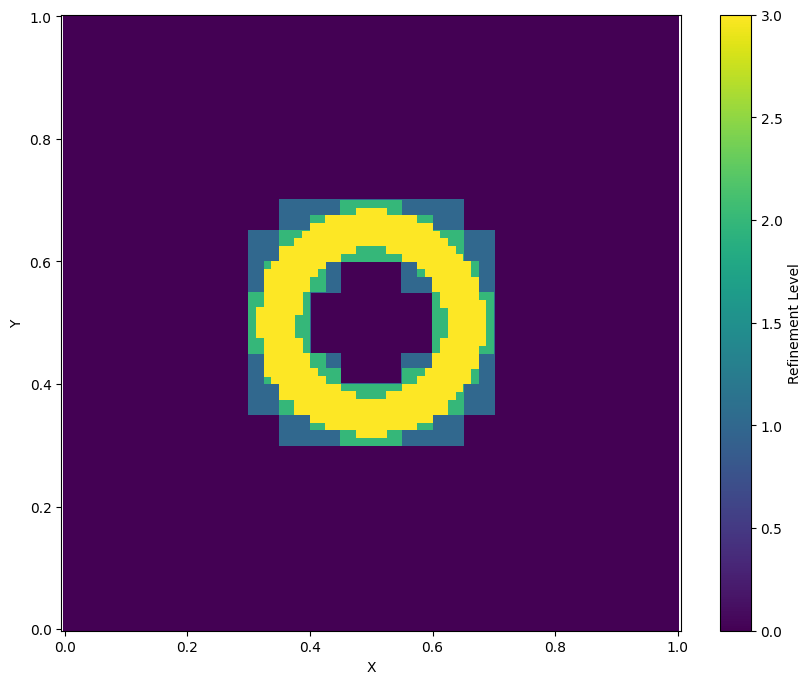

In [ ]:
# Density Contour
plt.figure(figsize=(10, 8))
ax = plt.gca()

component = 0
vrange = (0, 1)
fig = amraux.plot_block_data(blk_data0[:, component], blk_info0, ax, vrange) # Level 0
fig = amraux.plot_block_data(blk_data1[:, component], blk_info1, ax, vrange) # Level 1
fig = amraux.plot_block_data(blk_data2[:, component], blk_info2, ax, vrange) # Level 2
fig = amraux.plot_block_data(blk_data3[:, component], blk_info3, ax, vrange) # Level 3

plt.colorbar(fig, ax=ax, label='Density')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.axis('equal')
plt.show()

# Refinement Level
plt.figure(figsize=(10, 8))
ax = plt.gca()

component = 0
vrange = (0, 3)
fig = amraux.plot_block_data(0*jnp.ones_like(blk_data0[:, component]), blk_info0, ax, vrange) # Level 0
fig = amraux.plot_block_data(1*jnp.ones_like(blk_data1[:, component]), blk_info1, ax, vrange) # Level 1
fig = amraux.plot_block_data(2*jnp.ones_like(blk_data2[:, component]), blk_info2, ax, vrange) # Level 2
fig = amraux.plot_block_data(3*jnp.ones_like(blk_data3[:, component]), blk_info3, ax, vrange) # Level 3

plt.colorbar(fig, ax=ax, label='Refinement Level')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.axis('equal')
plt.show()